## Import Libraries

In [1]:
import os
import torch
import datasets
import timm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch.nn.functional as F
import math
import inspect

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('drive/MyDrive/Deep Learning Sample')

In [4]:
os.getcwd()

'/content/drive/MyDrive/Deep Learning Sample'

## Download Imagenet Class Labels

## Load All the images

In [5]:
os.listdir()

['ViT_Base_Activation_Attention_Maps_Capture.ipynb',
 'Sample Images',
 'ViT_Base_Train.ipynb',
 'imagenet_classes.txt']

In [6]:
os.listdir("Sample Images")

['Lena_image.png', 'cat_dog_image.png', 'car_image.jpg']

In [7]:
lena_img_path = "Sample Images/Lena_image.png"
cat_dog_img_path = "Sample Images/cat_dog_image.png"
car_img_path = "Sample Images/car_image.jpg"

In [8]:
lena_img_np = np.array(Image.open(lena_img_path))
cat_dog_img_np = np.array(Image.open(cat_dog_img_path))
car_img_np = np.array(Image.open(car_img_path))

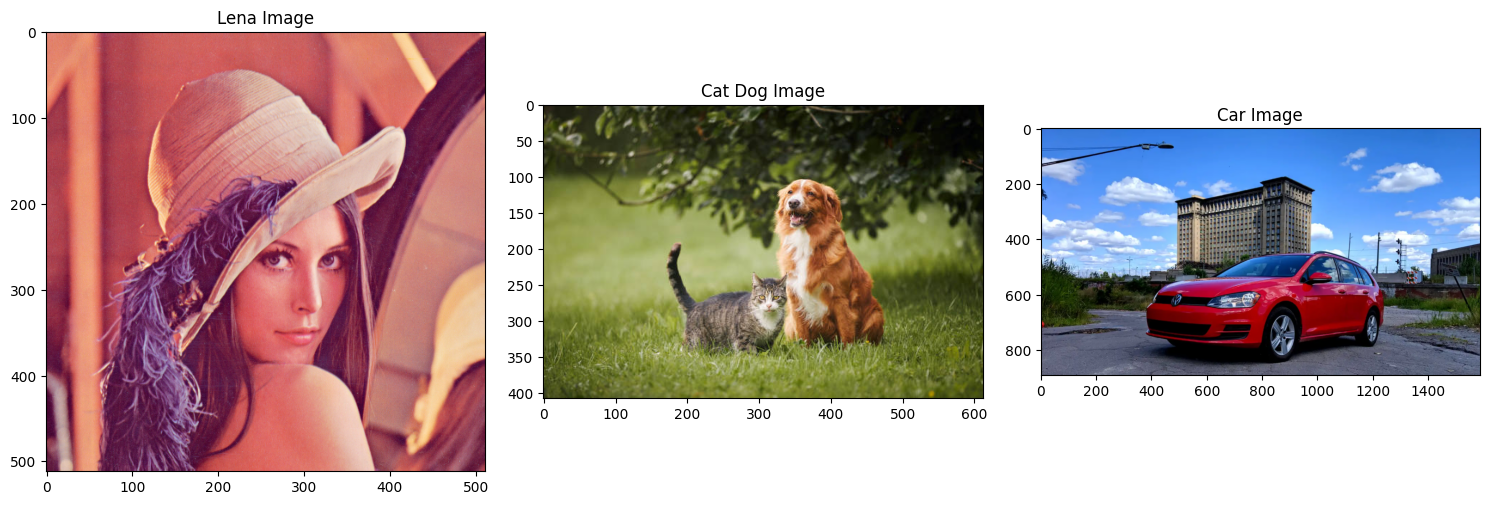

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(lena_img_np)
axes[0].set_title('Lena Image')
axes[0].axis('on')

axes[1].imshow(cat_dog_img_np)
axes[1].set_title('Cat Dog Image')
axes[1].axis('on')

axes[2].imshow(car_img_np)
axes[2].set_title('Car Image')
axes[2].axis('on')

plt.tight_layout()
plt.show()

## Preprocess images

In [10]:
def preprocess_img(img_np):
    img = torch.from_numpy(img_np).permute(2,0,1).float() / 255.0
    img = F.interpolate(img.unsqueeze(0), size=(224,224),
                        mode='bilinear', align_corners=False).squeeze(0)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    img = (img - mean) / std
    return img


In [11]:
print(f"{lena_img_np.shape=}")
print(f"{cat_dog_img_np.shape=}")
print(f"{car_img_np.shape=}")

lena_img_np.shape=(512, 512, 3)
cat_dog_img_np.shape=(408, 612, 3)
car_img_np.shape=(890, 1588, 3)


In [12]:
import torch.nn.functional as F

IMG_SIZE = 224

lena_img_tensor = preprocess_img(lena_img_np)
print(f"{lena_img_tensor.shape=}")

cat_dog_img_tensor = preprocess_img(cat_dog_img_np)
print(f"{cat_dog_img_tensor.shape=}")

car_img_tensor = preprocess_img(car_img_np)
print(f"{car_img_tensor.shape=}")

lena_img_tensor.shape=torch.Size([3, 224, 224])
cat_dog_img_tensor.shape=torch.Size([3, 224, 224])
car_img_tensor.shape=torch.Size([3, 224, 224])


## Select a Model

In [13]:
timm.list_models("*vit_tiny*", pretrained=True)

['convit_tiny.fb_in1k',
 'crossvit_tiny_240.in1k',
 'davit_tiny.msft_in1k',
 'gcvit_tiny.in1k',
 'maxvit_tiny_rw_224.sw_in1k',
 'maxvit_tiny_tf_224.in1k',
 'maxvit_tiny_tf_384.in1k',
 'maxvit_tiny_tf_512.in1k',
 'vit_tiny_patch16_224.augreg_in21k',
 'vit_tiny_patch16_224.augreg_in21k_ft_in1k',
 'vit_tiny_patch16_384.augreg_in21k_ft_in1k',
 'vit_tiny_r_s16_p8_224.augreg_in21k',
 'vit_tiny_r_s16_p8_224.augreg_in21k_ft_in1k',
 'vit_tiny_r_s16_p8_384.augreg_in21k_ft_in1k']

## Load the model

In [14]:
model = timm.create_model("vit_tiny_patch16_224.augreg_in21k_ft_in1k", pretrained=True)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


## Hooks to capture activations

In [15]:
activations_od = OrderedDict()

In [16]:
len(model._modules['blocks'])

12

In [17]:
model._modules['blocks'][11]

Block(
  (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=192, out_features=576, bias=True)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (proj): Linear(in_features=192, out_features=192, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=192, out_features=768, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=768, out_features=192, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

Here I am trying to capture activation, for a forward hook there are three inputs, the module the hook is applied to, input tensor to that module, and the output of that module, since we are need activation we need the output tensor of each layer.

Before writing the hook, you need to examine the model architecture

I am using hook_handles to keep track of the hooks that I register. At the end of the entire pipeline, I can remove the hooks easily.

If I don't remove hooks, each time I run this below code cell, new hook will be registerd resulting in duplicate outputs.

Since each hook adds computation, depending on the processing you do inside the hook, hooks can slow down inference/training

In [18]:
hook_handles = []

In [19]:
def get_activations(name:str):
  def activation_hook(module, input, output):
    activations_od[name] = output.detach()
  return activation_hook

In [20]:

# Add hooks to all the blocks to layerwise activations
for i, block in enumerate(model._modules['blocks']):
  h = block.register_forward_hook(get_activations(f"block_{i}"))
  hook_handles.append(h)

## Hooks to capture Attention Maps

Attention Map is the most important place when it comes to information flow. Because information mixing (information from one token to another token flows throught attention maps) happens.

 \text{Softmax}(Q K^\top)

In [21]:
model._modules['blocks'][11].attn

Attention(
  (qkv): Linear(in_features=192, out_features=576, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (norm): Identity()
  (proj): Linear(in_features=192, out_features=192, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

In [22]:
print(inspect.getsource(model._modules['blocks'][11].attn.forward))


    def forward(
            self,
            x: torch.Tensor,
            attn_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        q, k = self.q_norm(q), self.k_norm(k)

        if self.fused_attn:
            x = F.scaled_dot_product_attention(
                q, k, v,
                attn_mask=attn_mask,
                dropout_p=self.attn_drop.p if self.training else 0.,
            )
        else:
            q = q * self.scale
            attn = q @ k.transpose(-2, -1)
            attn = maybe_add_mask(attn, attn_mask)
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.norm(x)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x



In [23]:
model._modules['blocks'][11].attn.fused_attn

True

In [24]:
model._modules['blocks'][11].attn.fused_attn = False

Since `self.fused_attn` is `True`, we can't capture attention map directly. (We can do it by manually setting for all the layer_idx, `model._modules['blocks'][layer_idx].attn.fused_attn = False` and then directly capture `attn`, but for this example let's consider the worst case, when you can't capture attention map directly.)

This `F.scaled_dot_product_attention` does not inherit from `nn.Module()`, therefore we cannot define hooks for this

This is the line responsible for calculating q, k embeddings before calculating attention.

```q, k = self.q_norm(q), self.k_norm(k)```

In [25]:
model._modules['blocks'][11].attn.q_norm

Identity()

In [26]:
model._modules['blocks'][11].attn.k_norm

Identity()

If we register hooks for these layers, we can capture q, k embeddings separately. Then after some processing using

```python
q = q * self.scale
attn = q @ k.transpose(-2, -1)
```

We can get the attention map.

In [27]:
attention_maps_od = OrderedDict()
q_embeddings_od = OrderedDict()
k_embeddings_od = OrderedDict()

In [28]:
type(model._modules['blocks'][11].attn.scale), model._modules['blocks'][11].attn.scale

(float, 0.125)

In [29]:
def get_query_activations(name:str, q_scale:float):
  def query_activation_hook(module, input, output):
    q_embeddings_od[name] = output.detach() * q_scale # Here we need to pass q_scale as well, just like in the source code
  return query_activation_hook

def get_key_activations(name:str):
  def key_activation_hook(module, input, output):
    k_embeddings_od[name] = output.detach()
  return key_activation_hook

In [30]:

# Add hooks to all the blocks to layerwise activations
for i, block in enumerate(model._modules['blocks']):
  attn_block = block._modules['attn']
  # print(attn_block)
  # print(attn_block.scale)


  h1 = attn_block.q_norm.register_forward_hook(get_query_activations(f"block_{i}", attn_block.scale))
  h2 = attn_block.k_norm.register_forward_hook(get_key_activations(f"block_{i}"))
  hook_handles.append(h1)
  hook_handles.append(h2)


I am going to add another hooks to compute the attention map, right after the attention map. It is certain that the MLP layer is called right after the attention map. This might not be the best way to compute attn_map, But I need to compute along the forward pass

Note that I have ignored the attention mask, because in our case we are using an image, no need to mask tokens.

In [31]:
def get_attention_maps(name:str):
  def compute_attn_map_hook(module, input, output):
    print(name)
    q = q_embeddings_od[name]
    k = k_embeddings_od[name]
    print("\tq shape", q.shape)
    print("\tk shape", k.shape)
    attn = q @ k.transpose(-2, -1)
    print("\tAttention Map shape before softmax", attn.shape)
    attention_maps_od[name] = attn.softmax(dim=-1)
    print("\tAttention Map shape after softmax", attention_maps_od[name].shape)


  return compute_attn_map_hook


In [32]:
# Add hooks to trigger computing the attenion maps
for i, block in enumerate(model._modules['blocks']):

  mlp_block = block._modules['mlp']
  # Forward function of 'MLP' block is guranteed to call after Attention block, There are some implementations
  # layer(x) = MLP(x) + Attn(x) but in our case layer(x) = MLP(Attn(x)) ( I found this implementation in Moondream VLM model,
  # so please inspect carefully before using this way)

  h = mlp_block.register_forward_hook(get_attention_maps(f"block_{i}"))
  hook_handles.append(h)

## Inference

In [33]:
x = cat_dog_img_tensor.unsqueeze(0)
with torch.inference_mode():
  output = model(x)


block_0
	q shape torch.Size([1, 3, 197, 64])
	k shape torch.Size([1, 3, 197, 64])
	Attention Map shape before softmax torch.Size([1, 3, 197, 197])
	Attention Map shape after softmax torch.Size([1, 3, 197, 197])
block_1
	q shape torch.Size([1, 3, 197, 64])
	k shape torch.Size([1, 3, 197, 64])
	Attention Map shape before softmax torch.Size([1, 3, 197, 197])
	Attention Map shape after softmax torch.Size([1, 3, 197, 197])
block_2
	q shape torch.Size([1, 3, 197, 64])
	k shape torch.Size([1, 3, 197, 64])
	Attention Map shape before softmax torch.Size([1, 3, 197, 197])
	Attention Map shape after softmax torch.Size([1, 3, 197, 197])
block_3
	q shape torch.Size([1, 3, 197, 64])
	k shape torch.Size([1, 3, 197, 64])
	Attention Map shape before softmax torch.Size([1, 3, 197, 197])
	Attention Map shape after softmax torch.Size([1, 3, 197, 197])
block_4
	q shape torch.Size([1, 3, 197, 64])
	k shape torch.Size([1, 3, 197, 64])
	Attention Map shape before softmax torch.Size([1, 3, 197, 197])
	Attentio

In [34]:
# output shape (1, 1000)
probabilities = torch.nn.functional.softmax(output, dim=-1)
top5_prob, top5_indices = torch.topk(probabilities, 5)

# Read the ImageNet class labels
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

top_prob, top_idx = torch.topk(probabilities, 1)
print("Top 5 predictions:")
for i in range(5):
    cls_label = categories[top5_indices[0, i]]
    prob = top5_prob[0, i].item()
    print(f"{cls_label:<20} {prob:.4f}")


Top 5 predictions:
bloodhound           0.1940
Cardigan             0.0847
EntleBucher          0.0785
German shepherd      0.0714
Irish setter         0.0594


## Sanity Check

In [35]:
import torch
import matplotlib.pyplot as plt

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

def visualize_tensor(x, normalized=True):
    print("Input shape:", x.shape)

    # Remove batch dimension if present
    if x.dim() == 4 and x.shape[0] == 1:
        x = x[0]

    # Remove extra dim if shaped like (1, 3, 224, 224)
    while x.dim() > 3:
        x = x.squeeze(0)

    # Now x must be (3, H, W)
    if x.dim() != 3:
        raise ValueError(f"Expected 3D image tensor, got {x.dim()}D")

    # Denorm
    if normalized:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        x = x * std + mean

    img = x.permute(1, 2, 0).clamp(0,1).cpu().numpy()

    plt.imshow(img)
    plt.axis("off")
    plt.show()

def sanity_check(x, output, categories=None, normalized=True):
    print("=== INPUT CHECK ===")
    print("shape:", x.shape)                          # (1, 3, 224, 224)
    print("dtype:", x.dtype)
    print("min / max / mean:", x.min().item(), x.max().item(), x.mean().item())
    print("contains NaNs:", torch.isnan(x).any().item())

    print("\n=== MODEL OUTPUT CHECK ===")
    print("output shape:", output.shape)              # (1, 1000)
    print("output contains NaNs:", torch.isnan(output).any().item())

    probs = output.softmax(dim=-1)
    print("softmax sum:", probs.sum().item())         # should be ~1

    top_prob, top_idx = probs.topk(5)
    print("\n=== TOP-5 PREDICTIONS ===")
    for i in range(5):
        # Use top_idx for class label, and handle cases where categories might still be None
        cls_label = categories[top_idx[0, i]] if categories else f"Index: {top_idx[0, i].item()}"
        print(f"{cls_label:<20} {top_prob[0, i].item():.4f}")

    print("\n=== VISUALIZATION ===")
    visualize_tensor(x, normalized=normalized)


=== INPUT CHECK ===
shape: torch.Size([1, 3, 224, 224])
dtype: torch.float32
min / max / mean: -2.117535352706909 2.51375150680542 -0.41202208399772644
contains NaNs: False

=== MODEL OUTPUT CHECK ===
output shape: torch.Size([1, 1000])
output contains NaNs: False
softmax sum: 0.9999998807907104

=== TOP-5 PREDICTIONS ===
bloodhound           0.1940
Cardigan             0.0847
EntleBucher          0.0785
German shepherd      0.0714
Irish setter         0.0594

=== VISUALIZATION ===
Input shape: torch.Size([1, 3, 224, 224])


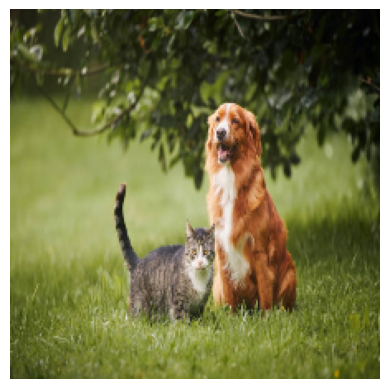

In [36]:
sanity_check(x, output, categories=categories)

## Delete Hooks

In [37]:
for h in hook_handles:
    h.remove()


## Process Hooks Outputs

In [38]:
for k, v in activations_od.items():
    print(k, v.shape)


block_0 torch.Size([1, 197, 192])
block_1 torch.Size([1, 197, 192])
block_2 torch.Size([1, 197, 192])
block_3 torch.Size([1, 197, 192])
block_4 torch.Size([1, 197, 192])
block_5 torch.Size([1, 197, 192])
block_6 torch.Size([1, 197, 192])
block_7 torch.Size([1, 197, 192])
block_8 torch.Size([1, 197, 192])
block_9 torch.Size([1, 197, 192])
block_10 torch.Size([1, 197, 192])
block_11 torch.Size([1, 197, 192])


## Visualize Activations

### Activation Visualization for one layer

In [39]:
# Remove batch dimension & Removd [CLS] token & take mean so that I can get one 1 vector
activation_patches = activations_od['block_0'].squeeze(0)[1:,:].mean(dim=-1)
activation_patches.shape # [196]

NUM_PATCHES = int(math.sqrt(activation_patches.shape[0]))
NUM_PATCHES # 14

IMG_SIZE # 224

PATCH_SIZE = int(activation_patches.shape[0] / NUM_PATCHES) # 16

In [40]:
# Reshape to 2D grid
activation_grid = activation_patches.view(NUM_PATCHES, NUM_PATCHES)  # [14, 14]



In [41]:
INTERPOLATION_METHOD = 'nearest'  # ['nearest' , 'bilinear' ]

activation_map = activation_grid.unsqueeze(0).unsqueeze(0)  # [1, 1, 14, 14]

if INTERPOLATION_METHOD == 'nearest':
  # Upsample to image size using nearest neighbor (each value becomes 16x16 block)
  activation_resized = F.interpolate(
      activation_map,
      size=(IMG_SIZE, IMG_SIZE),  # [224, 224]
      mode='nearest'
  ) # [1, 1, 224, 224]

elif INTERPOLATION_METHOD == 'bilinear':
  activation_resized = F.interpolate(
    activation_map,
    size=(IMG_SIZE, IMG_SIZE),  # [224, 224]
    mode='bilinear',
    align_corners=False
)

activation_resized = activation_resized.squeeze()  # [224, 224]



In [42]:
activation_resized.shape

torch.Size([224, 224])

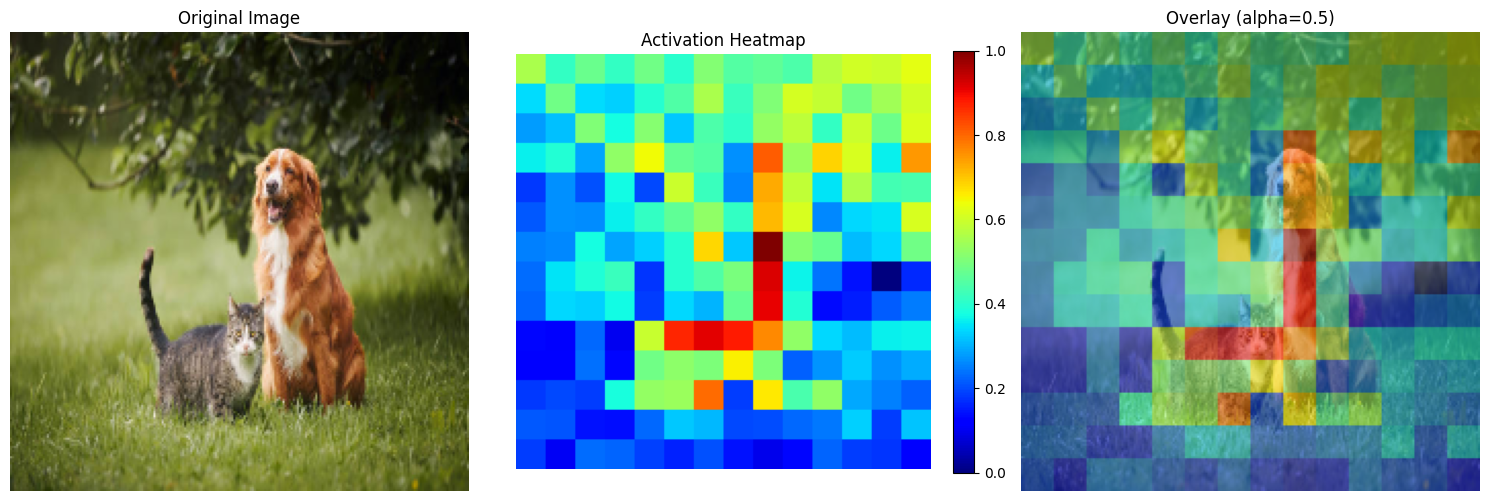

In [43]:
def visualize_activation_overlay(x, activation_map, normalized=True, alpha=0.5, cmap='jet'):
    """
    Overlay activation heatmap on original image

    Args:
        x: Image tensor (1, 3, 224, 224) or (3, 224, 224)
        activation_map: Activation heatmap (224, 224)
        normalized: Whether x is ImageNet normalized
        alpha: Transparency of heatmap (0=invisible, 1=opaque)
        cmap: Colormap for heatmap ('jet', 'viridis', 'hot', etc.)
    """
    # Process image
    if x.dim() == 4 and x.shape[0] == 1:
        x = x[0]

    # Denormalize if needed
    if normalized:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        x = x * std + mean

    # Convert to numpy (H, W, 3)
    img = x.permute(1, 2, 0).clamp(0, 1).cpu().numpy()

    # Normalize activation map to [0, 1]
    act = activation_map.cpu().numpy()
    act = (act - act.min()) / (act.max() - act.min() + 1e-8)

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Heatmap only
    heatmap = axes[1].imshow(act, cmap=cmap)
    axes[1].set_title('Activation Heatmap')
    axes[1].axis('off')
    plt.colorbar(heatmap, ax=axes[1], fraction=0.046)

    # Overlay
    axes[2].imshow(img)
    axes[2].imshow(act, cmap=cmap, alpha=alpha)
    axes[2].set_title(f'Overlay (alpha={alpha})')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


visualize_activation_overlay(x, activation_resized, normalized=True, alpha=0.5)

### Activation Visualization over layers

In [44]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import math

def visualize_all_layers(x, activations_od, normalized=True, alpha=0.5, cmap='jet', interpolation='bilinear'):
    """
    Visualize activation heatmaps for all layers

    Args:
        x: Image tensor (1, 3, 224, 224)
        activations_od: OrderedDict with activations from all layers
        normalized: Whether x is ImageNet normalized
        alpha: Transparency of overlay
        cmap: Colormap for heatmap
        interpolation: 'nearest' or 'bilinear'
    """
    # Process original image once
    if x.dim() == 4 and x.shape[0] == 1:
        x_img = x[0]

    if normalized:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        x_img = x_img * std + mean

    img = x_img.permute(1, 2, 0).clamp(0, 1).cpu().numpy()

    # Get number of layers
    num_layers = len(activations_od)

    # Create figure: 2 rows (heatmap, overlay) x num_layers columns
    fig, axes = plt.subplots(2, num_layers, figsize=(4 * num_layers, 8))

    # Handle single layer case
    if num_layers == 1:
        axes = axes.reshape(2, 1)

    for idx, (layer_name, activation_tensor) in enumerate(activations_od.items()):
        # Process activation
        # Remove batch dimension & Remove [CLS] token & take mean
        activation_patches = activation_tensor.squeeze(0)[1:, :].mean(dim=-1)  # [196] or [N]

        NUM_PATCHES = int(math.sqrt(activation_patches.shape[0]))
        IMG_SIZE = x.shape[-1]  # 224

        # Reshape to 2D grid
        activation_grid = activation_patches.view(NUM_PATCHES, NUM_PATCHES)

        # Upsample to image size
        activation_map = activation_grid.unsqueeze(0).unsqueeze(0)

        if interpolation == 'nearest':
            activation_resized = F.interpolate(
                activation_map,
                size=(IMG_SIZE, IMG_SIZE),
                mode='nearest'
            )
        else:  # bilinear
            activation_resized = F.interpolate(
                activation_map,
                size=(IMG_SIZE, IMG_SIZE),
                mode='bilinear',
                align_corners=False
            )

        activation_resized = activation_resized.squeeze()  # [224, 224]

        # Normalize activation to [0, 1]
        act = activation_resized.cpu().numpy()
        act = (act - act.min()) / (act.max() - act.min() + 1e-8)

        # Row 0: Heatmap only
        im = axes[0, idx].imshow(act, cmap=cmap)
        axes[0, idx].set_title(f'{layer_name}\nHeatmap')
        axes[0, idx].axis('off')
        plt.colorbar(im, ax=axes[0, idx], fraction=0.046)

        # Row 1: Overlay
        axes[1, idx].imshow(img)
        axes[1, idx].imshow(act, cmap=cmap, alpha=alpha)
        axes[1, idx].set_title(f'{layer_name}\nOverlay')
        axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()



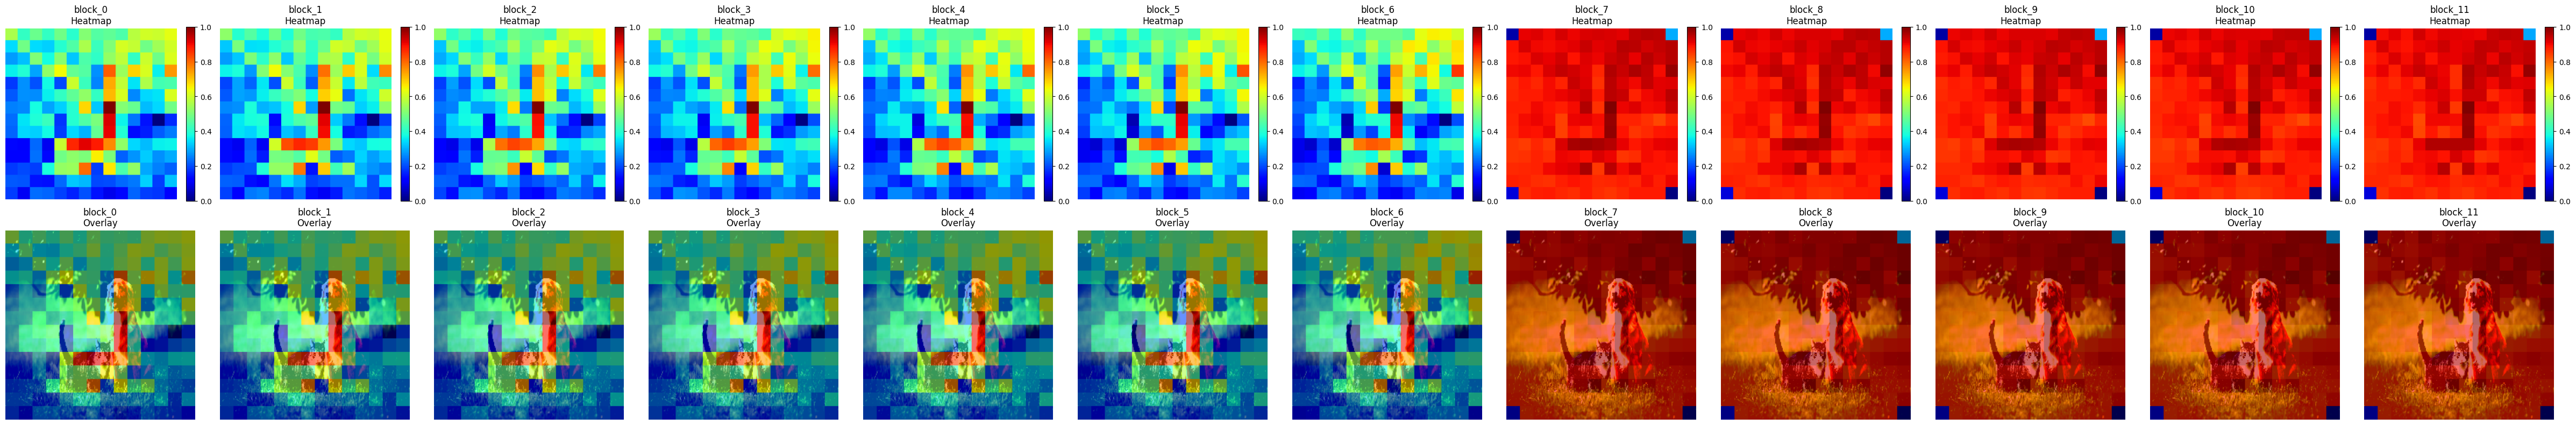

In [45]:
visualize_all_layers(x, activations_od, normalized=False, alpha=0.6, interpolation='nearest') # Here there is a bug in mean error

In [46]:
# Check activation statistics for each layer
for layer_name, activation_tensor in activations_od.items():
    activation_patches = activation_tensor.squeeze(0)[1:, :].mean(dim=-1)

    print(f"\n{layer_name}:")
    print(f"  Mean: {activation_patches.mean():.4f}")
    print(f"  Std:  {activation_patches.std():.4f}")
    print(f"  Min:  {activation_patches.min():.4f}")
    print(f"  Max:  {activation_patches.max():.4f}")
    print(f"  Range: {(activation_patches.max() - activation_patches.min()):.4f}")


block_0:
  Mean: -0.0706
  Std:  0.0665
  Min:  -0.2075
  Max:  0.1447
  Range: 0.3522

block_1:
  Mean: -0.0545
  Std:  0.0619
  Min:  -0.1846
  Max:  0.1514
  Range: 0.3360

block_2:
  Mean: -0.0568
  Std:  0.0610
  Min:  -0.1851
  Max:  0.1482
  Range: 0.3332

block_3:
  Mean: -0.0530
  Std:  0.0605
  Min:  -0.1815
  Max:  0.1484
  Range: 0.3298

block_4:
  Mean: -0.0511
  Std:  0.0593
  Min:  -0.1766
  Max:  0.1461
  Range: 0.3227

block_5:
  Mean: -0.0455
  Std:  0.0584
  Min:  -0.1641
  Max:  0.1456
  Range: 0.3097

block_6:
  Mean: -0.0473
  Std:  0.0588
  Min:  -0.1632
  Max:  0.1392
  Range: 0.3024

block_7:
  Mean: -0.0755
  Std:  0.2112
  Min:  -1.6499
  Max:  0.1304
  Range: 1.7802

block_8:
  Mean: -0.0818
  Std:  0.2110
  Min:  -1.6529
  Max:  0.1241
  Range: 1.7770

block_9:
  Mean: -0.0815
  Std:  0.2111
  Min:  -1.6535
  Max:  0.1283
  Range: 1.7818

block_10:
  Mean: -0.0854
  Std:  0.2111
  Min:  -1.6547
  Max:  0.1287
  Range: 1.7834

block_11:
  Mean: -0.0719
  St

## Visualize Attention Maps


In [48]:
len(attention_maps_od)

12

In [49]:
attention_maps_od['block_0'].shape

torch.Size([1, 3, 197, 197])

In [54]:
model.patch_embed

PatchEmbed(
  (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
)

In [53]:
model.blocks[0].attn.num_heads

3

When image is processed in ViT-Tiny to get patch embeddings, `Conv2d` layer is used with 192 filters with 3 kernels per each filter (16x16) with stride 16.

So in the later layers, we have 192 features to process. In each layer, there are `3` heads. Therefore each head is responsible for processing 192/3 = 64 features. This results in one attention map per each attention head.

Notice in `attention_maps_od['block_0'].shape` = (1, 3, 197, 197) `3` is the number of attention maps (number of attention heads) per layer, and `197` refers to the number of tokens.

197 = [CLS] token + 196 image Patch tokens (In ViT)

If we considered DeiT model, there should be another token responsible for distillation.

### Visualize Attention Map of a Single Layer

In [59]:
# Sanity check to see whether the sum is 1 along the row axis (Considering only one attention head)
attention_maps_od['block_0'].squeeze(0)[0, 0, :].sum()

tensor(1.0000)

In [62]:
# Get the mean about heads
attention_maps_od['block_0'].squeeze(0)[:, :, :].mean(dim=0).shape

torch.Size([197, 197])

In [71]:
# Only consider the first row because first row is "How [CLS] token attends to itself and other image patch tokens"
attention_maps_od['block_0'].squeeze(0)[:, : , :].mean(dim=0)[0,:].shape

torch.Size([197])

In [78]:
# Now we can remove the first element of this row, that elements shows how [CLS] token attends to itself
attn_slice = attention_maps_od['block_0'].squeeze(0)[:, : , :].mean(dim=0)[0,1:]
attn_slice.shape

torch.Size([196])

In [82]:
# now I am going to use softmax so that we will get a new probability distribtution after removing the first element
attn_slice = F.softmax(attn_slice, dim=0)
attn_slice.shape

torch.Size([196])

In [84]:
NUM_PATCHES = int(math.sqrt(attention_maps_od['block_0'].squeeze(0)[:, : , :].mean(dim=0)[0,1:].shape[0]))
attn_slice = attn_slice.view(NUM_PATCHES, NUM_PATCHES)
attn_slice.shape

torch.Size([14, 14])

In [92]:
for k, v in attention_maps_od.items():
    print(k, v.shape)

block_0 torch.Size([1, 3, 197, 197])
block_1 torch.Size([1, 3, 197, 197])
block_2 torch.Size([1, 3, 197, 197])
block_3 torch.Size([1, 3, 197, 197])
block_4 torch.Size([1, 3, 197, 197])
block_5 torch.Size([1, 3, 197, 197])
block_6 torch.Size([1, 3, 197, 197])
block_7 torch.Size([1, 3, 197, 197])
block_8 torch.Size([1, 3, 197, 197])
block_9 torch.Size([1, 3, 197, 197])
block_10 torch.Size([1, 3, 197, 197])
block_11 torch.Size([1, 3, 197, 197])


In [88]:
def visualize_attention_overlay_simple(x, attn_slice, normalized=True, alpha=0.6, cmap='jet', interpolation='nearest'):
    """Simple single-plot overlay"""
    # Process image
    if x.dim() == 4 and x.shape[0] == 1:
        x_img = x[0]

    if normalized:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        x_img = x_img * std + mean

    img = x_img.permute(1, 2, 0).clamp(0, 1).cpu().numpy()

    # Upsample attention
    IMG_SIZE = x.shape[-1]
    attn_map = attn_slice.unsqueeze(0).unsqueeze(0)

    if interpolation == 'bilinear':
        attn_resized = F.interpolate(attn_map, size=(IMG_SIZE, IMG_SIZE),
                                     mode='bilinear', align_corners=False)
    elif interpolation == 'nearest':
        attn_resized = F.interpolate(attn_map, size=(IMG_SIZE, IMG_SIZE), mode='nearest')

    attn_resized = attn_resized.squeeze().cpu().numpy()

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.imshow(attn_resized, cmap=cmap, alpha=alpha)
    plt.axis('off')
    plt.colorbar(fraction=0.046)
    plt.title('Attention Map Overlay')
    plt.show()



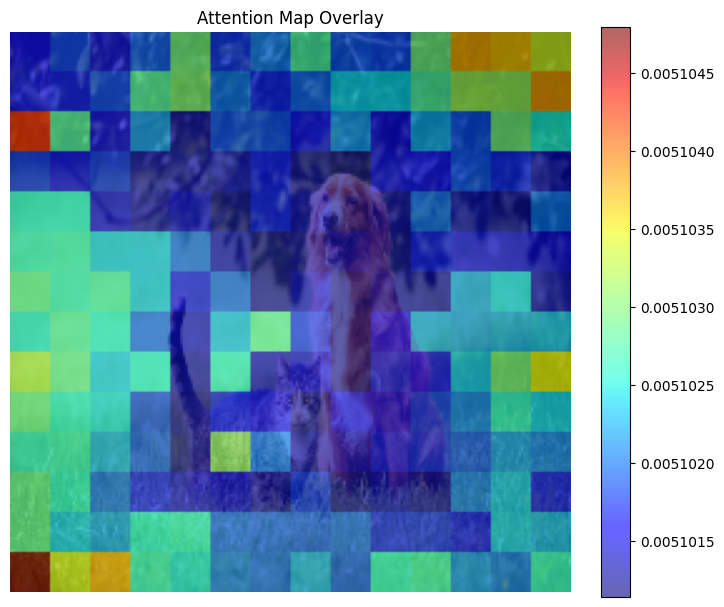

In [89]:
# Usage
visualize_attention_overlay_simple(x, attn_slice, alpha=0.6)

In [83]:
attn_slice.shape

torch.Size([196])

In [91]:
# Check if attention slice values are properly normalized
print(f"Attention shape: {attn_slice.shape}")
print(f"Min: {attn_slice.min():.4f}")
print(f"Max: {attn_slice.max():.4f}")
print(f"Mean: {attn_slice.mean():.4f}")
print(f"Sum: {attn_slice.sum():.4f}")  # Should be ~1.0 if normalized across patches

Attention shape: torch.Size([14, 14])
Min: 0.0051
Max: 0.0051
Mean: 0.0051
Sum: 1.0000


### Visualize Attention Maps over all the layers

In [97]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_attention_grid(x, attention_maps_od, slice_idx=0, normalized=True, alpha=0.6, cmap='jet', interpolation='nearest'):
    """
    Visualize attention maps across layers in a grid.
    - Horizontal axis: layers
    - Vertical axis: top row = attention heatmap, bottom row = overlay with original image
    """
    # Process image
    x_img = x[0]
    if normalized:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        x_img = x_img * std + mean
    img = x_img.permute(1, 2, 0).clamp(0, 1).cpu().numpy()

    num_layers = len(attention_maps_od)
    fig, axes = plt.subplots(2, num_layers, figsize=(4*num_layers, 8))

    if num_layers == 1:
        axes = axes[:, None]  # ensure axes is 2D

    for col, (layer_name, attn_tensor) in enumerate(attention_maps_od.items()):
        # Average over heads
        attn_slice = attn_tensor.squeeze(0).mean(dim=0)[slice_idx, 1:]  # remove CLS token

        # Upsample
        N = int((attn_slice.shape[0])**0.5)
        attn_map = attn_slice.view(1, 1, N, N)
        if interpolation == 'bilinear':
            attn_resized = F.interpolate(attn_map, size=(x.shape[-1], x.shape[-1]),
                                         mode='bilinear', align_corners=False)
        else:
            attn_resized = F.interpolate(attn_map, size=(x.shape[-1], x.shape[-1]), mode='nearest')
        attn_resized = attn_resized.squeeze().cpu().numpy()

        # Top row: attention heatmap
        axes[0, col].imshow(attn_resized, cmap=cmap)
        axes[0, col].axis('off')
        axes[0, col].set_title(f'{layer_name} Heatmap', fontsize=10)

        # Bottom row: overlay
        axes[1, col].imshow(img)
        axes[1, col].imshow(attn_resized, cmap=cmap, alpha=alpha)
        axes[1, col].axis('off')
        axes[1, col].set_title(f'{layer_name} Overlay', fontsize=10)

    plt.tight_layout()
    plt.show()


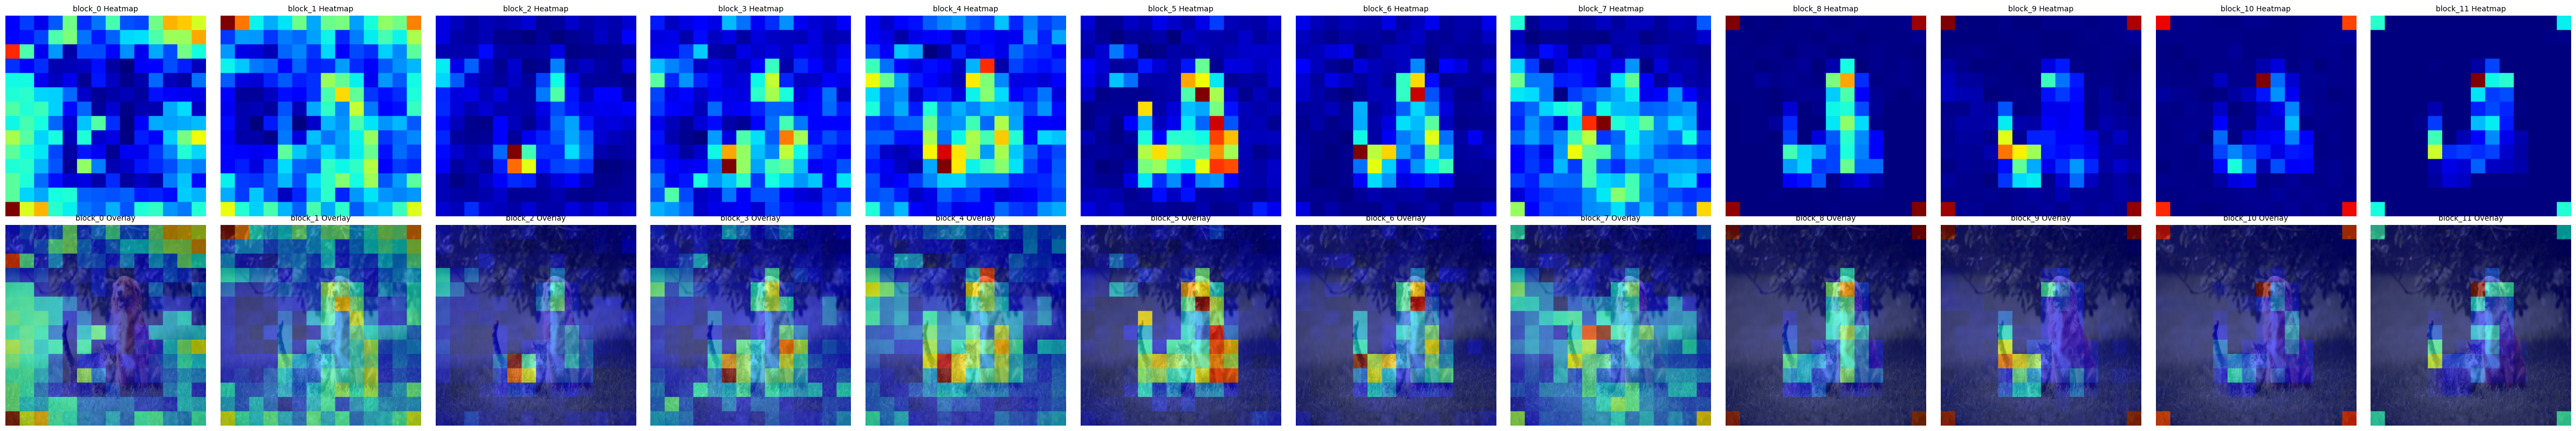

In [98]:
visualize_attention_grid(x, attention_maps_od, slice_idx=0)